# Modelo Sandwich: Dentro 50% Ni, Fuera 50% Pt
## Empezamos por hacer nuestro shell
en este caso ya tenía hecho el shell, solamente voy a operar con él. Lo hice a partir de un shell sin posiciones exactas

In [1]:
from sys import path
import os
dir_actual = os.getcwd()
path.insert(0, 'C:/Users/guill/OneDrive/Documentos/Tesis/Proyect')

import myfuncions.tools_f as tools
import subprocess as sbp

name='Ni_0.5_sandwich.xyz'
atpos, eleList = tools.leer_xyz(name)
tools.show_percent(atpos,eleList)

sbp.run(['java', '-jar', 'C:\\Users\\guill\\Downloads\\Jmol-16.1.41-binary\\jmol-16.1.41\\Jmol.jar', name])

atomos totales : 1157
Pt : 51.16681071737251 %, 592
Ni : 48.83318928262749 %, 565


CompletedProcess(args=['java', '-jar', 'C:\\Users\\guill\\Downloads\\Jmol-16.1.41-binary\\jmol-16.1.41\\Jmol.jar', 'Ni_0.5_sandwich.xyz'], returncode=0)

este es el modelo:

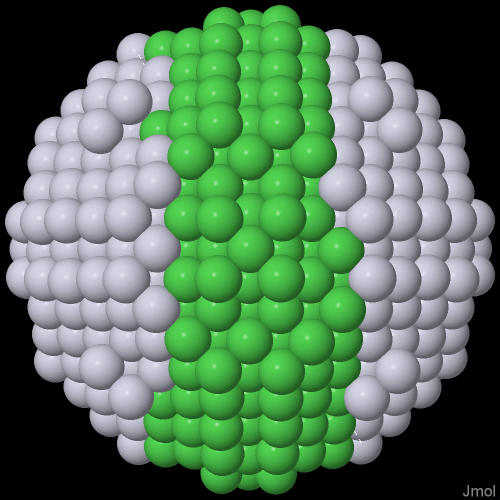

Trabajamos con lammpin

In [2]:
from myfuncions.lammpin_f import wlammpin
wlammpin(atpos,eleList,name)

Ni_0.5_sandwich.ini


## Dinámica Molecular empieza aquí
Hacemos 600 pasos de rescale a 0K, 3000 pasos de rampa hacia 300K con berendsen y 3000 pasos de termalización con langevin a 300K

In [3]:

input = f"""
# 2NN EAM potential in LAMMPS

 units		metal
 atom_style	atomic
 boundary	f f f

 read_data	{name[:-4]}.ini
 pair_style	meam
 pair_coeff	* * ..\\..\\LAMMPS\\library.meam Pt Ni ..\\..\\LAMMPS\\PtNiV2.pot Pt Ni 
 
 neighbor	0.5 bin
 neigh_modify	every 1 delay 0 check yes once no
 velocity	all create 0.00 13478 rot yes mom yes dist gaussian
 timestep	0.005

 fix            1 all nve
 fix            2 all temp/rescale 10 0.00 0.00 1.0 1
 thermo         100
 thermo_style   custom step temp atoms pe ke etotal
 thermo_modify  lost ignore
 run 600

 unfix 2
 fix         3 all temp/berendsen 0.0 300.0 0.1
 thermo		100
 run		3000

 unfix 3
 timestep   0.001
 thermo		100
 fix		4 all langevin 300.0 300.0 0.5 87654
 dump       4 all xyz 1 dump_temp.xyz
 undump     4
 run        1
 dump       4 all xyz 599 {name[:-4]}_d.xyz
 run		599
"""
with open('input.in','w') as archivo:
    archivo.write(input)

os.system('start powershell -Command lmp -in input.in; Start-Sleep -s 20; exit')

0

## Ahora hacemos el análisis de distribución del dump
La siguiente función cuenta los atomos que hay entr $r$ y $r+\Delta r$, lo ideal es darle un $\Delta r \approx$ radio atómico del atomo de interés (1.4 $\AA$ para el Pt), aquí también se cambian las etiquetas en atpos, $\Delta r$ puede ser cualquier valor sin embargo he encontrado que se obtienen mejores resultados así

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Cambia etiquetas a "atpos"
jala


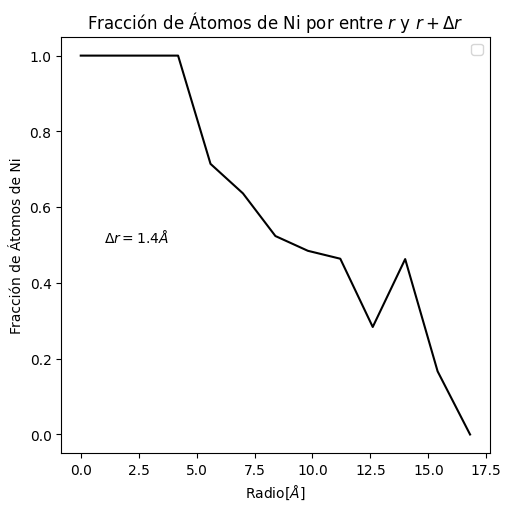

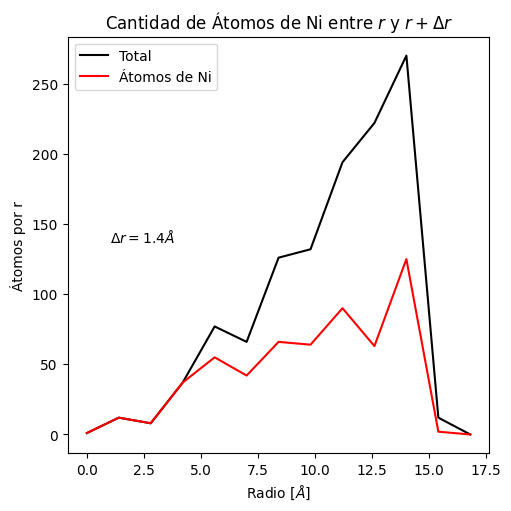

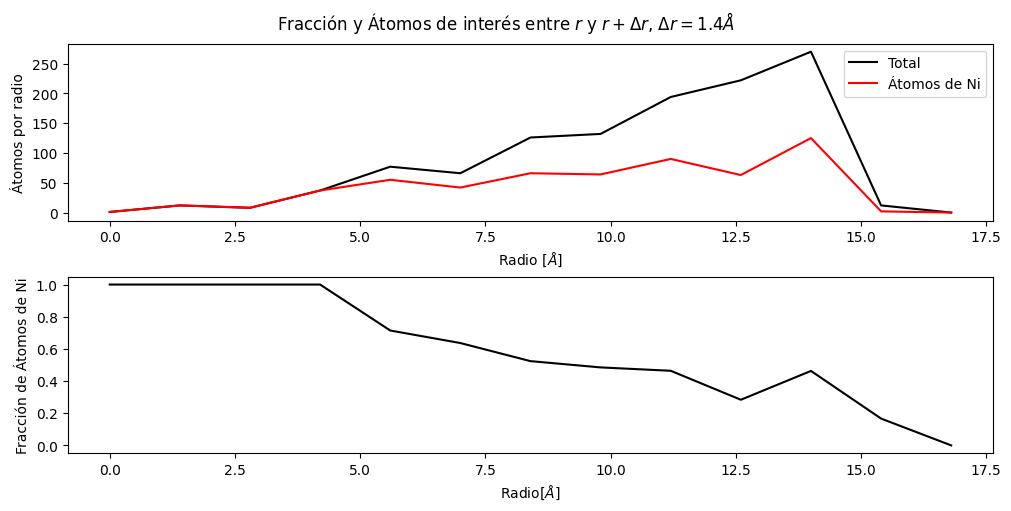

In [4]:
import myfuncions.graphs_f as gf
datpos, deleList = tools.leer_xyz(f'{name[:-4]}_d.xyz')
datpos, deleList = tools.cambiar_etiquetas_xyz(datpos, deleList, {1: 'Ni', 2: 'Pt'})

gf.dump_graficar_fracc_atpr(datpos,'Ni',1.4)
gf.dump_graficar_atpr(datpos,'Ni',1.4)
gf.plot_dump_f_y_atpr(datpos,'Ni',1.4)

### A trabajar con el dump
Lo mostramos de nuevo

In [5]:
tools.wXYZ(datpos,f'{name[:-4]}_d.xyz')

sbp.run(['java', '-jar', 'C:\\Users\\guill\\Downloads\\Jmol-16.1.41-binary\\jmol-16.1.41\\Jmol.jar', f'{name[:-4]}_d.xyz'])

CompletedProcess(args=['java', '-jar', 'C:\\Users\\guill\\Downloads\\Jmol-16.1.41-binary\\jmol-16.1.41\\Jmol.jar', 'Ni_0.5_sandwich_d.xyz'], returncode=0)

Este es el dump: Se ve la perdida de estructura en el lado del Niquel

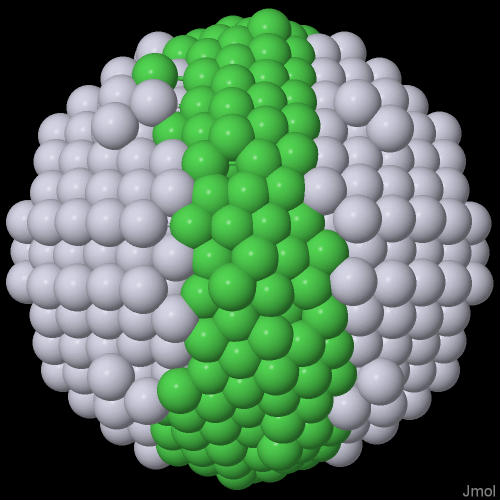

## Aquí se hace el PDF y la gráfica


In [6]:
import PDF.runner as pdf
pdf.run_pdf(f'{name[:-4]}_d.xyz', dir_actual, 1700,0.02)

c:\Users\guill\OneDrive\Documentos\Tesis\Proyect\1_de_marzo_notebooks\Ni_0.5_sandwich

   2.68099997E-02  -7.18600005E-02  -15.0202999              78   61996.0000    
  -4.11405993      -7.86943007      -10.8696003              78   61996.0000    
  -8.26300010E-02  -8.04230022      -10.9104996              78   61996.0000    
        1157  atomos       668746  pares 
 Rango de distancias    2.14295197     -   30.9122372    
 Distancias promedio    15.7153358    
 Factor de normalizacion    51971.9375    



#### Notese que el tamaño maximo de la partícula es de 30.8 $\AA$

Hacemos la gráfica PDF, se compara con un modelo de Pt 100% con MD

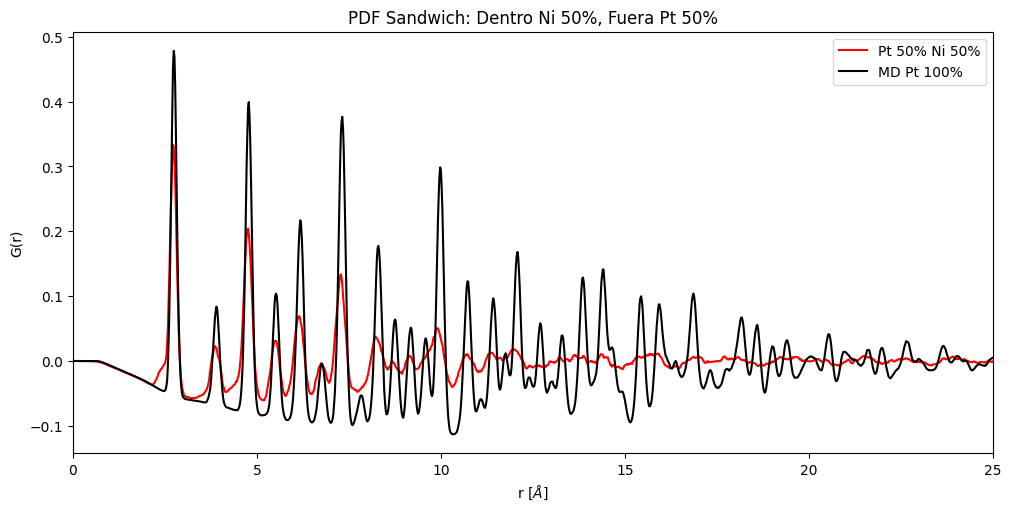

In [7]:
import pandas as pd
import matplotlib.pyplot as plt


df_FCC= pd.read_csv(f'{name[:-4]}_d.txt', sep='\s+')
df_ref = pd.read_csv('C:/Users/guill/OneDrive/Documentos/Tesis/Proyect/15_de_marzo/Pt_100/Pt-FCC_d.txt', sep = '\s+')


fig, ax =plt.subplots(figsize=(10,5), layout='constrained')
ax.plot(df_FCC['#r(A)'], df_FCC['G(r)'], label=f'Pt 50% Ni 50%', color = 'red')
ax.plot(df_ref['#r(A)'],df_ref['G(r)'], label = 'MD Pt 100%', color = 'black')


ax.set_xlabel('r [$\\AA$]')
ax.set_xlim([0,25])
ax.set_ylabel('G(r)')
ax.set_title('PDF Sandwich: Dentro Ni 50%, Fuera Pt 50%')
#ax.grid('True', linestyle='-')
ax.legend()
plt.show()

Ahora hacemos una gráfica comparando con un modelo de Ni 100% que tiene MD

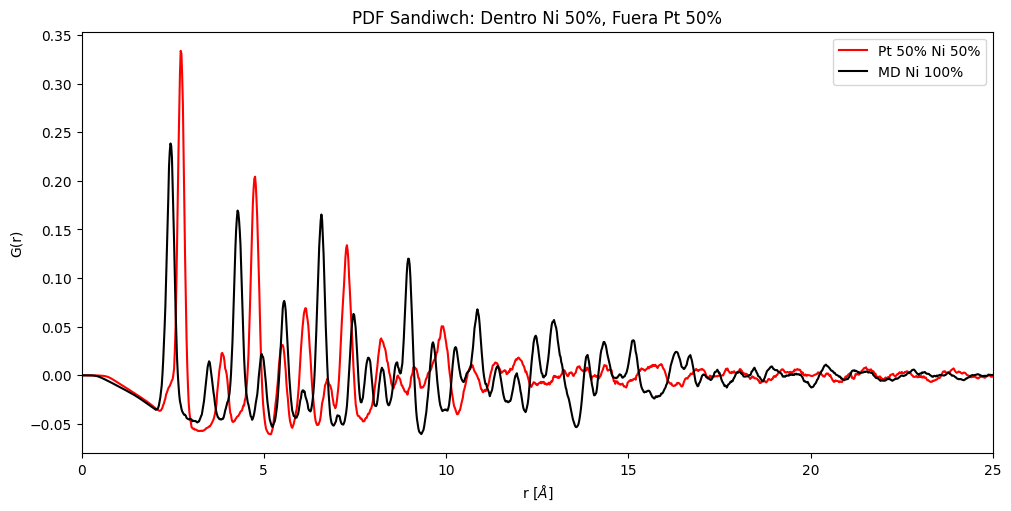

In [8]:
df_FCC= pd.read_csv(f'{name[:-4]}_d.txt', sep='\s+')
df_ref = pd.read_csv('C:/Users/guill/OneDrive/Documentos/Tesis/Proyect/15_de_marzo/Ni_100/Ni-FCC_d.txt', sep = '\s+')


fig, ax =plt.subplots(figsize=(10,5), layout='constrained')
ax.plot(df_FCC['#r(A)'], df_FCC['G(r)'], label=f'Pt 50% Ni 50%', color = 'red')
ax.plot(df_ref['#r(A)'],df_ref['G(r)'], label = 'MD Ni 100%', color = 'black')


ax.set_xlabel('r [$\\AA$]')
ax.set_xlim([0,25])
ax.set_ylabel('G(r)')
ax.set_title('PDF Sandiwch: Dentro Ni 50%, Fuera Pt 50%')
#ax.grid('True', linestyle='-')
ax.legend()
plt.show()